The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l


# Weight Decay

:label:`sec_weight_decay`


Now that we have characterized the problem of overfitting
and motivated the need for capacity control,
we can begin discussing some of the popular techniques
used to these ends in practice.
Recall that we can always mitigate overfitting
by going out and collecting more training data,
that can be costly and time consuming,
typically making it impossible in the short run.
For now, let's assume that we have already obtained
as much high-quality data as our resources permit
and focus on techniques aimed at limiting the capacity
of the function classes under consideration.

In our toy example,
we saw that we could control the complexity of a polynomial
by adjusting its degree.
However, most of machine learning
does not consist of polynomial curve fitting.
And moreover, even when we focus on polynomial regression,
when we deal with high-dimensional data,
manipulating model capacity by tweaking the degree $d$ is problematic.
To see why, note that for multivariate data
we must generalize the concept of polynomials
to include *monomials*, which are simply
products of powers of variables.
For example, $x_1^2 x_2$, and $x_3 x_5^2$ are both monomials of degree $3$.
The number of such terms with a given degree $d$
blows up as a function of the degree $d$.

Concretely, for vectors of dimensionality $D$,
the number of monomials of a given degree $d$ is ${D -1 + d} \choose {D-1}$.
Hence, a small change in degree, even from say $1$ to $2$ or $2$ to $3$
would entail a massive blowup in the complexity of our model.
Thus, tweaking the degree is too blunt a hammer.
Instead, we need a more fine-grained tool
for adjusting function complexity.

## Squared Norm Regularization

*Weight decay* (commonly called *L2* regularization),
might be the most widely-used technique
for regularizing parametric machine learning models.
The basic intuition behind weight decay is
the notion that among all functions $f$,
the function $f = 0$ is the simplest.
Intuitively, we can then measure functions by their proximity to zero.
But how precisely should we measure
the distance between a function and zero?
There is no single right answer.
In fact, entire branches of mathematics,
e.g., in functional analysis and the theory of Banach spaces
are devoted to answering this issue.

For our present purposes, a very simple interpretation will suffice:
We will consider a linear function
$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$
to be simple if its weight vector is small.
We can measure this via $||mathbf{w}||^2$.
One way of keeping the weight vector small
is to add its norm as a penalty term
to the problem of minimizing the loss.
Thus we replace our original objective,
*minimize the prediction error on the training labels*,
with new objective,
*minimize the sum of the prediction error and the penalty term*.
Now, if the weight vector becomes too large,
our learning algorithm will find more profit in
minimizing the norm $|| \mathbf{w} ||^2$
versus minimizing the training error.
That is exactly what we want.
To illustrate things in code, let's revive our previous example
from :numref:`sec_linear_regression` for linear regression.
There, our loss was given by

$$l(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

Recall that $\mathbf{x}^{(i)}$ are the observations,
$y^{(i)}$ are labels, and $(\mathbf{w}, b)$
are the weight and bias parameters respectively.
To arrive at a new loss function
that penalizes the size of the weight vector,
we need to add $||mathbf{w}||^2$, but how much should we add?
To address this, we need to add a new hyperparameter,
that we will call the *regularization constant* and denote by $\lambda$:

$$l(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2.$$

This non-negative parameter $\lambda \geq 0$
governs the amount of regularization.
For $\lambda = 0$, we recover our original loss function,
whereas for $\lambda > 0$ we ensure that $\mathbf{w}$ cannot grow too large. The astute reader might wonder why we are squaring
the norm of the weight vector.
We do this for two reasons.
First, we do it for computational convenience.
By squaring the L2 norm, we remove the square root,
leaving the sum of squares of each component of the weight vector.
This is convenient because it is easy to compute derivatives of a sum of terms (the sum of derivatives equals the derivative of the sum).

Moreover, you might ask, why the L2 norm in the first place and not the L1 norm, or some other distance function.
In fact, several other choices are valid
and are popular throughout statistics.
While L2-regularized linear models constitute
the classic *ridge regression* algorithm
L1-regularized linear regression
is a similarly fundamental model in statistics
popularly known as *lasso regression*.

One mathematical reason for working with the L2 norm and not some other norm,
is that it penalizes large components of the weight vector
much more than it penalizes small ones.
This encourages our learning algorithm to discover models
which distribute their weight across a larger number of features,
which might make them more robust in practice
since they do not depend precariously on a single feature.
The stochastic gradient descent updates for L2-regularized regression
are as follows:

$$
\begin{aligned}
w & \leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right),
\end{aligned}
$$

As before, we update $\mathbf{w}$ based on the amount
by which our estimate differs from the observation.
However, we also shrink the size of $\mathbf{w}$ towards $0$.
That is why the method is sometimes called "weight decay":
because the penalty term literally causes our optimization algorithm
to *decay* the magnitude of the weight at each step of training.
This is more convenient than having to pick
the number of parameters as we did for polynomials.
In particular, we now have a continuous mechanism
for adjusting the complexity of $f$.
Small values of $\lambda$ correspond to unconstrained $\mathbf{w}$,
whereas large values of $\lambda$ constrain $\mathbf{w}$ considerably.
Since we do not want to have large bias terms either,
we often add $b^2$ as a penalty, too.

## High-Dimensional Linear Regression

For high-dimensional regression it is difficult
to pick the 'right' dimensions to omit.
Weight-decay regularization is a much more convenient alternative.
We will illustrate this below.
First, we will generate some synthetic data as before

$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01).$$

representing our label as a linear function of our inputs,
corrupted by Gaussian noise with zero mean and variance 0.01.
To observe the effects of overfitting more easily,
we can make our problem high-dimensional,
setting the data dimension to $d = 200$
and working with a relatively small number of training 
examples---here we will set the sample size to 20:

In [1]:
%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 1
true_w, true_b = np.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## Implementation from Scratch

Next, we will show how to implement weight decay from scratch.
All we have to do here is to add the squared $\ell_2$ penalty
as an additional loss term added to the original target function.
The squared norm penalty derives its name from the fact
that we are adding the second power $\sum_i w_i^2$.
The $\ell_2$ is just one among an infinite class of norms call p-norms,
many of which you might encounter in the future.
In general, for some number $p$, the $\ell_p$ norm is defined as

$$\|\mathbf{w}\|_p^p := \sum_{i=1}^d |w_i|^p.$$

### Initializing Model Parameters

First, we will define a function to randomly initialize our model parameters and run `attach_grad` on each to allocate memory for the gradients we will calculate.

In [2]:
def init_params():
    w = np.random.normal(scale=1, size=(num_inputs, 1))
    b = np.zeros(1)
    w.attach_grad()
    b.attach_grad()
    return [w, b]

### Defining $\ell_2$ Norm Penalty

Perhaps the most convenient way to implement this penalty
is to square all terms in place and sum them up.
We divide by $2$ by convention
(when we take the derivative of a quadratic function,
the $2$ and $1/2$ cancel out, ensuring that the expression
for the update looks nice and simple).

In [3]:
def l2_penalty(w):
    return (w**2).sum() / 2

### Defining the Train and Test Functions

The following code defines how to train and test the model
separately on the training dataset and the test dataset.
Unlike the previous sections, here, the $\ell_2$ norm penalty term
is added when calculating the final loss function.
The linear network and the squared loss
have not changed since the previous chapter,
so we will just import them via `d2l.linreg` and `d2l.squared_loss`
to reduce clutter.

In [4]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], legend=['train', 'test'])
    for epoch in range(1, num_epochs + 1):
        for X, y in train_iter:
            with autograd.record():
                # The L2 norm penalty term has been added
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        if epoch % 5 == 0:
            animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss),
                                   d2l.evaluate_loss(net, test_iter, loss)))
    print('l1 norm of w:', np.abs(w).sum())

### Training without Regularization

Next, let's train and test the high-dimensional linear regression model.
When `lambd = 0` we do not use weight decay.
As a result, while the training error decreases, the test error does not.
This is a perfect example of overfitting.

l1 norm of w: 152.89601


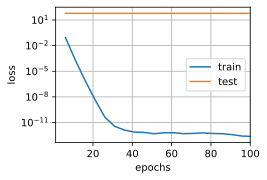

In [5]:
train(lambd=0)

### Using Weight Decay

The example below shows that even though the training error increased,
the error on the test set decreased.
This is precisely the improvement that we expect from using weight decay.
While not perfect, overfitting has been mitigated to some extent.
In addition, the $\ell_2$ norm of the weight $\mathbf{w}$
is smaller than without using weight decay.

l1 norm of w: 0.30113873


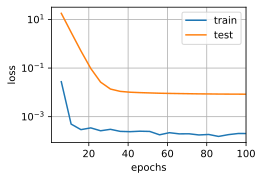

In [6]:
train(lambd=3)

## Concise Implementation

Because weight decay is ubiquitous in neural network optimization,
Gluon makes it especially convenient,
integrating weight decay into the optimization algorithm itself
for easy use in combination with any loss function.
Moreover, this integration serves a computational benefit,
allowing implementation tricks to add weight decay to the algorithm,
without any additional computational overhead.
Since the weight decay portion of the update
depends only on the current value of each parameter,
and the optimizer must to touch each parameter once anyway.

In the following code, we specify
the weight decay hyperparameter directly
through `wd` when instantiating our `Trainer`.
By default, Gluon decays both weights and biases simultaneously.
Note that the hyperparameter `wd` will be multiplied by `wd_mult`
when updating model parameters. Thus, by setting `wd_mult` to $0$
the bias parameter $b$ will not decay.

In [7]:
def train_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    loss = gluon.loss.L2Loss()
    num_epochs, lr = 100, 0.003
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr, 'wd': wd})
    # The bias parameter has not decayed. Bias names generally end with "bias"
    net.collect_params('.*bias').setattr('wd_mult', 0)
    
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], legend=['train', 'test'])
    for epoch in range(1, num_epochs+1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        if epoch % 5 == 0:
            animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss),
                                   d2l.evaluate_loss(net, test_iter, loss)))
    print('L1 norm of w:', np.abs(net[0].weight.data()).sum())

The plots look just the same as when we implemented weight decay from scratch
but they run a bit faster and are easier to implement,
a benefit that will become more pronounced for large problems.

L1 norm of w: 163.57816


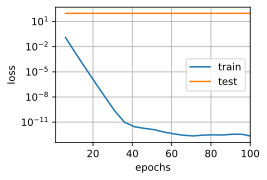

In [8]:
train_gluon(0)

L1 norm of w: 0.3096568


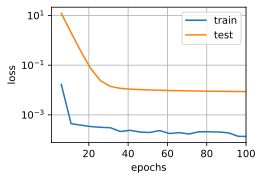

In [9]:
train_gluon(3)

So far, we only touched upon one notion of
what constitutes a simple *linear* function.
For nonlinear functions, what constitutes *simplicity*
can be a far more complex question.
For instance, there exist [Reproducing Kernel Hilbert Spaces (RKHS)](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)
which allow one to use many of the tools
introduced for linear functions in a nonlinear context.
Unfortunately, RKHS-based algorithms
do not always scale well to massive amounts of data.
For the purposes of this book, we limit ourselves
to simply summing over the weights for different layers,
e.g., via $\sum_l \|\mathbf{w}_l\|^2$,
which is equivalent to weight decay applied to all layers.


## Summary

* Regularization is a common method for dealing with overfitting. It adds a penalty term to the loss function on the training set to reduce the complexity of the learned model.
* One particular choice for keeping the model simple is weight decay using an $\ell_2$ penalty. This leads to weight decay in the update steps of the learning algorithm.
* Gluon provides automatic weight decay functionality in the optimizer by setting the hyperparameter `wd`.
* You can have different optimizers within the same training loop, e.g., for different sets of parameters.


## Exercises

1. Experiment with the value of $\lambda$ in the estimation problem in this page. Plot training and test accuracy as a function of $\lambda$. What do you observe?
1. Use a validation set to find the optimal value of $\lambda$. Is it really the optimal value? Does this matter?
1. What would the update equations look like if instead of $\|\mathbf{w}\|^2$ we used $\sum_i |w_i|$ as our penalty of choice (this is called $\ell_1$ regularization).
1. We know that $\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$. Can you find a similar equation for matrices (mathematicians call this the [Frobenius norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm))?
1. Review the relationship between training error and generalization error. In addition to weight decay, increased training, and the use of a model of suitable complexity, what other ways can you think of to deal with overfitting?
1. In Bayesian statistics we use the product of prior and likelihood to arrive at a posterior via $P(w \mid x) \propto P(x \mid w) P(w)$. How can you identify $P(w)$ with regularization?

## [Discussions](https://discuss.mxnet.io/t/2342)

![](../img/qr_weight-decay.svg)